# Dynamic Bistable Hidden Markov Model
## A case study comparing BeanMachine-based MCMC inference with Rejection ABC

In this notebook, we will walk through performing inference for a Bistable Hidden Markov Model (HMM) with BeanMachine MCMC and compare it with handwritten Approximate Bayesian Computation (ABC) Inference.

Note: Model referred to from doi:10.1371/journal.pcbi.1002803.g002

The Bistable HMM model is used in several biological and non-equilibirium themodynamic systems. An intutive visual example is bistable perception, where our visual perception of ambgious 2D image cycles between two stable configurations in 3D. See the following image, can you make out the two percepts?: 

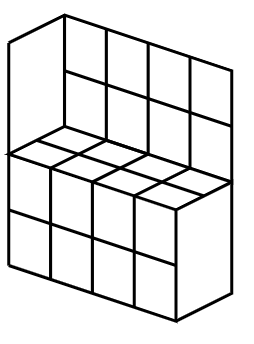


The (biological) dynamical model consists of two states: A and B. If the probability of a transition from one state to the other is defined as $\theta$ in both directions, the probability to remain in the same state at each time step is 1 - $\theta$. The probability to measure the state correctly is $\gamma$ (conversely, the probability of an incorrect measurement is 1- $\gamma$.)
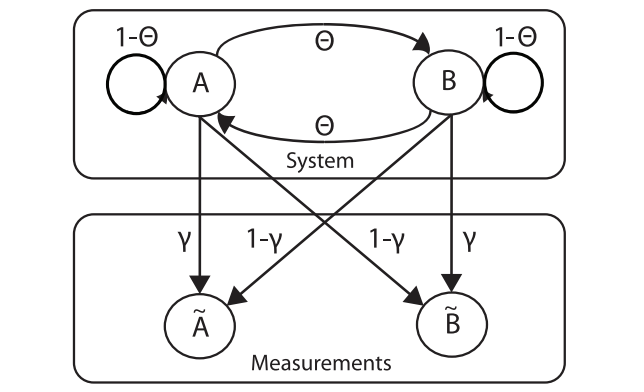
Due to various conditional dependencies across timesteps, likelihood of time series data can be tedious, which is why we choose this example to demonstrate ABC.

In [17]:
# Importing the required libraries
import matplotlib.pyplot as plt

import beanmachine.ppl as bm
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

## Model definition

Let the hidden state and measured state of the system at time t be denoted by S(t) and M(t) respectively. 

For any given time t:

If S(t) = A,

P(S(t+1) = A) = 1- $\theta$; P(S(t+1) = B) = $\theta$

P(M(t+1) = A | S(t+1) = A) = $\gamma$; P(M(t+1)) = B | S(t+1) = A) = 1 - $\gamma$

Below we build the model using torch distributions so we can simulate some ground truth data. For ease we denote state A with 0 and state B with 1. Values for $\theta$ and $\gamma$ are typical and obtained from the referred work.

In [18]:
true_theta = 0.25

true_gamma = 0.99

num_observations = 1000

# tensorized data generator model
measurement_data = torch.zeros([num_observations])
internal_states = torch.zeros([num_observations])
def S(i):
    if i == 0:
        # start with default state 0
        internal_states[i] = torch.zeros(1)
        return internal_states[i]
    else:
        # current state opposite from previous with p=theta and same as previous with p=1-theta
        internal_states[i] = dist.Bernoulli((true_theta * (torch.ones(1) - internal_states[i-1])) 
                                   + (torch.ones(1) - true_theta) * internal_states[i-1]).sample()
        return internal_states[i]
def M(i):
    if i < num_observations:
        # measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
        hidden_state = S(i)
        measurement_data[i] = dist.Bernoulli((true_gamma * hidden_state) 
                                   + ((torch.ones(1) - true_gamma) * (1 - hidden_state))).sample()
        M(i+1)
    else:
        return measurement_data

## Generate mesurements from the model

In [19]:
# Generate data
M(0)

# let's print some for sanity check
print ([internal_states[i].item() for i in range(20)])
print ([measurement_data[i].item() for i in range(20)])

[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Run Inference with BeanMachine

Now we will set up priors and perform inference with Beanmachine as a baseline. First step is to write the Bistable HMM model in beanmachine:

In [20]:
# priors for theta and gamma 
@bm.random_variable
def theta():
    # according to paper this should be uniform 0,1
    return dist.Uniform(0, 1)

@bm.random_variable
def gamma():
    # we believe measurements to be accurate
    return dist.Beta(5, 0.75)

# the model
@bm.random_variable
def hidden_state(i):
    if i == 0:
        # start with default state 0
        return dist.Bernoulli(0)
    else:
        # current state opposite from previous with p=theta and same as previous with p=1-theta
        return dist.Bernoulli((theta() * (1 - hidden_state(i - 1)) 
                                   + (1 - theta()) * hidden_state(i - 1)))
    
@bm.random_variable
def measured_state(i):
    # measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
    return dist.Bernoulli((gamma() * hidden_state(i) 
                               + (1 - gamma()) * (1 - hidden_state(i))))

Next step is to run inference on this model using observations generated earlier:

In [21]:
ci = bm.CompositionalInference()

num_samples = 1000

num_chains = 1

# pack obervations in format compatible to BeanMachine
observations_bm = {measured_state(i): measurement_data[i] for i in range(num_observations)}

# kick off inference process
samples = ci.infer([theta(), gamma()], observations_bm, num_samples, num_chains)

Samples collected: 100%|██████████| 1000/1000 [37:47<00:00,  2.27s/it]


Now we visualize the posterior and run diagnostics:

In [22]:
bm.Diagnostics(samples).summary([theta(), gamma()])

,avg,std,2.5%,50%,97.5%,n_eff
gamma()[],0.972665,0.026631,0.883447,0.975141,0.995988,10.612501
theta()[],0.241682,0.029138,0.202769,0.242275,0.295243,14.859939


In [23]:
bm.Diagnostics(samples).plot(display=True)

[Figure({
     'data': [{'mode': 'lines',
               'name': 'chain0',
               'type': 'scatter',
               'x': [0, 1, 2, ..., 997, 998, 999],
               'xaxis': 'x',
               'y': array([0.3141948 , 0.3814671 , 0.3814671 , ..., 0.22218865, 0.22218865,
                           0.22218865], dtype=float32),
               'yaxis': 'y'}],
     'layout': {'annotations': [{'font': {'size': 16},
                                 'showarrow': False,
                                 'text': 'theta() trace for []',
                                 'x': 0.225,
                                 'xanchor': 'center',
                                 'xref': 'paper',
                                 'y': 1.0,
                                 'yanchor': 'bottom',
                                 'yref': 'paper'}],
                'template': '...',
                'xaxis': {'anchor': 'y', 'domain': [0.0, 0.45]},
                'xaxis2': {'anchor': 'y2', 'domain': [0.55, 1

Text(0, 0.5, 'frequency')

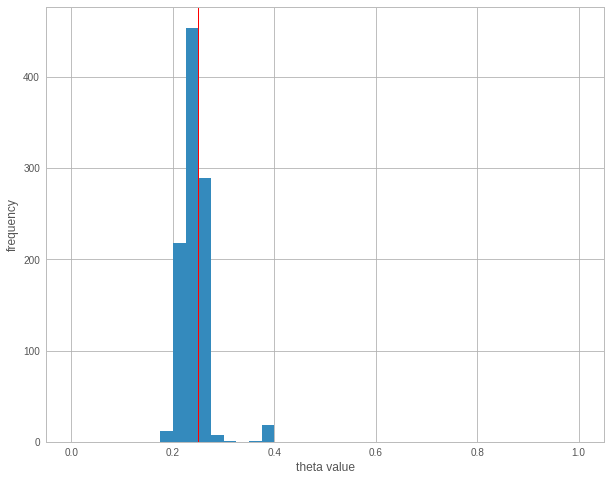

In [24]:
# plot posterior over theta
# code from N272056 thanks @Walid
plt.figure(figsize=(10,8))
r = [0.0,1.0]
plt.hist([s for s in samples[theta()][0]], bins=40, range=r)
plt.axvline(x=true_theta, c='red', linewidth=1)
plt.xlabel("theta value")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

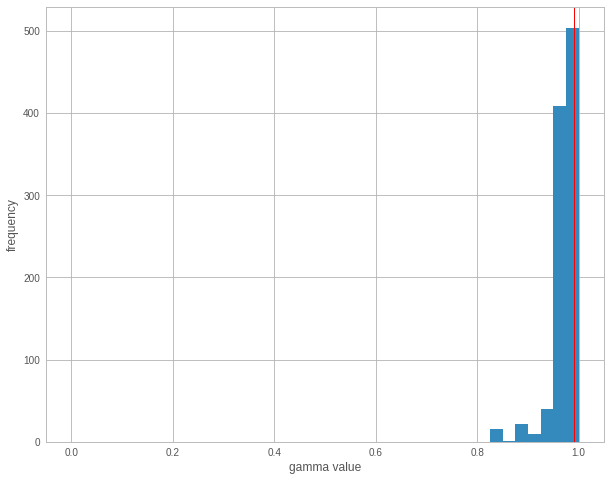

In [25]:
# plot posterior over gamma
# code from N272056 thanks @Walid
plt.figure(figsize=(10,8))
r = [0.0,1.0]
plt.hist([s for s in samples[gamma()][0]], bins=40, range=r)
plt.axvline(x=true_gamma, c='red', linewidth=1)
plt.xlabel("gamma value")
plt.ylabel("frequency")

## Run inference on model with hand-coded rejection ABC
As a next step, we will perform rejection ABC on the same model to obtain posterior over the parameters. To do so we need the following:
- A summary statistic S: We will use this to gauge the quality of the generated data in comparison with observed data. Here we use the frequency of switches as a summary statistic. 
- A distance function $\rho$: to quantify the difference between generated data and observed data in the summary statistic. Here we use absolute distance, i.e. difference.
- Tolerence $\epsilon$: This is the threshold of acceptance, i.e. we will accept a sample if distance in summary statistic is within this range. We will choose tolerance of 10% as per the example in the paper.

In [26]:
def switch_frequency(abc_samples):
    """
    Summary statistic for rejection ABC for bistable HMM model. 
    inputs: 1D binary array
    output: switching frequency of the array
    """
    switch_count = torch.tensor(0.)
    num_abc_samples = len(abc_samples)
    for i in range(1,num_abc_samples):
        if abc_samples[i] != abc_samples[i - 1]:
            switch_count += 1
    return switch_count/num_abc_samples


def abs_difference(freq_1, freq_2):
    return torch.abs(freq_1 - freq_2)

# we accept samples with switch frequency within 10% of observed samples
tolerence = 0.1

# we also compute the switch frequency of observed data
obs_switch_freq = switch_frequency([measurement_data[i].item() for i in range(num_observations)])

print(f"Switching frequency of data: {obs_switch_freq}")

Switching frequency of data: 0.26499998569488525


Now we define the rejection ABC version of the model:

In [27]:
# Priors: we will keep same priors as MH infernce
theta_prior = dist.Uniform(0, 1)
gamma_prior = dist.Beta(5, 0.75)

# number of parameter samples to consider in each iteration
N = 5000

# generate N samples each of theta and gamma from their prior
samples_theta = theta_prior.sample(torch.Size([N]))
samples_gamma = gamma_prior.sample(torch.Size([N]))

# tensorized data generator model
generated_data = torch.zeros([N,num_observations])
internal_states = torch.zeros([N, num_observations])


def S(i):
    if i == 0:
        # start with default state 0
        internal_states[:,i] = torch.zeros(N)
        return internal_states[:,i]
    else:
        # current state opposite from previous with p=theta and same as previous with p=1-theta
        internal_states[:, i] = dist.Bernoulli((samples_theta * (torch.ones(N) - internal_states[:, i-1])) 
                                   + (torch.ones(N) - samples_theta) * internal_states[:, i-1]).sample()
        return internal_states[:,i]

    
def M(i):
    if i < num_observations:
        # measured state same as hidden state with p=gamma and opposite from hidden state with p=1-gamma 
        hidden_state = S(i)
        generated_data[:,i] = dist.Bernoulli((samples_gamma * hidden_state 
                                   + (torch.ones(N) - samples_gamma) * (1 - hidden_state))).sample()
        M(i+1)
    else:
        return generated_data

With everything in place, we will now start Rejection ABC process:

In [28]:
%%time
# perform 1 iteration of rejection ABC
M(0)

# compute summary statistic
sample_switch_frequencies = [switch_frequency(generated_data[i]) for i in range(N)]   

# perform rejection
sample_accepted = torch.tensor([1 if abs_difference(obs_switch_freq, sample_switch_frequencies[i]) <= tolerence else 0 for i in range(N)])
accepted_theta = samples_theta[sample_accepted.nonzero()]
accepted_gamma = samples_gamma[sample_accepted.nonzero()]

CPU times: user 50 s, sys: 18 ms, total: 50 s
Wall time: 50 s


Now we visualize posterior and compute statstics:

In [13]:
# posterior statistics
acceptance_rate = accepted_theta.shape[0]/N
print(f"After one step of rejection ABC: \
            \n\nNumber of parameter samples: {N} \
            \nMean of accepted theta: {accepted_theta.mean()} \
            \nVariance of accepted theta: {accepted_theta.var()} \
            \nMean of accepted gamma: {accepted_gamma.mean()} \
            \nVariance of accepted gamma: {accepted_gamma.var()} \
            \nAcceptance rate: {acceptance_rate}\n ")

After one step of rejection ABC:             

Number of parameter samples: 5000             
Mean of accepted theta: 0.1969437301158905             
Variance of accepted theta: 0.009532900527119637             
Mean of accepted gamma: 0.9231062531471252             
Variance of accepted gamma: 0.003553129266947508             
Acceptance_rate: 0.1976
 


Text(0, 0.5, 'frequency')

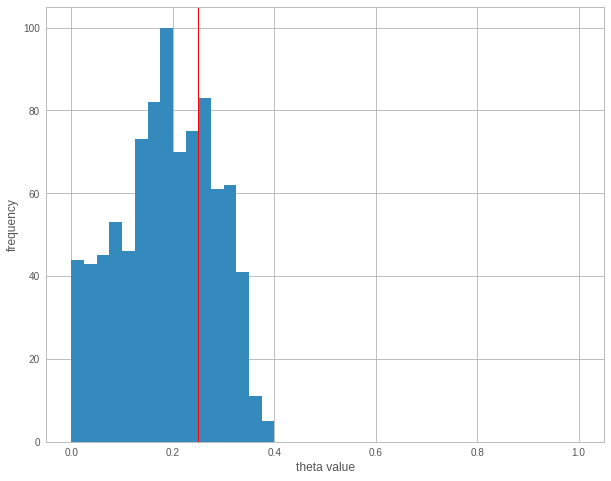

In [29]:
# plot posterior over theta
# code from N272056 thanks @Walid
plt.figure(figsize=(10,8))
r = [0.0,1.0]
plt.hist(accepted_theta.T, bins=40, range=r)
plt.axvline(x=true_theta, c='red', linewidth=1)
plt.xlabel("theta value")
plt.ylabel("frequency")

Text(0, 0.5, 'frequency')

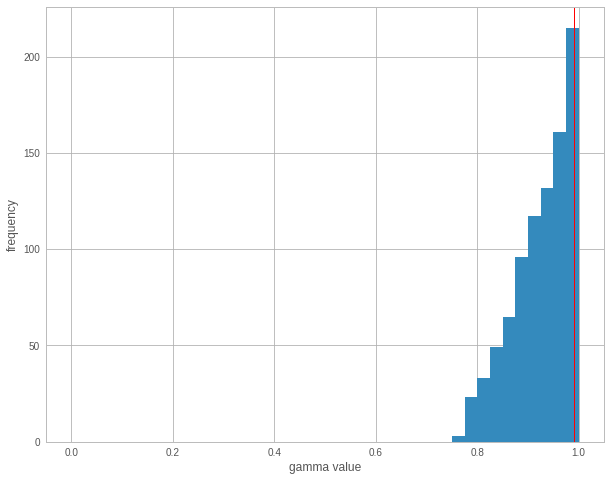

In [30]:
# plot posterior over gamma
# code from N272056 thanks @Walid
plt.figure(figsize=(10,8))
r = [0.0,1.0]
plt.hist(accepted_gamma.T, bins=40, range=r)
plt.axvline(x=true_gamma, c='red', linewidth=1)
plt.xlabel("gamma value")
plt.ylabel("frequency")